In [1]:
import scipy
from itertools import combinations_with_replacement

from scipy.stats import wasserstein_distance
from setup import neurotransmitters, model_size, device, feat_dim, resize_size, dataset_path, curated_idx, few_shot_transforms, model
from setup import tqdm, torch, np, os, h5py, sns, plt, tqdm, Trans
from perso_utils import get_fnames, load_image
from DINOSim import DinoSim_pipeline
from napari_dinosim.utils import get_img_processing_f
# Create an instance of the pipeline (not just assigning the class)

few_shot = DinoSim_pipeline(model,
                            model.patch_size,
                            device,
                            get_img_processing_f(resize_size),
                            feat_dim, 
                            dino_image_size=resize_size
                            )

Device: cpu


Using cache found in /Users/tomw/.cache/torch/hub/facebookresearch_dinov2_main
/Users/tomw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/tomw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/tomw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded


# Embedding space analysis

In [ ]:
saved_ref_embeddings = True # (but has to be done again)

data_aug = False

if saved_ref_embeddings == False:

    files, labels = zip(*get_fnames()) 

    if data_aug:    
        nb_transformations = len(few_shot_transforms)
        
        # Preload images and metadata once
        good_images = []
        transformed_coordinates = []

        for idx in curated_idx:
            img, coord_x, coord_y = load_image(files[idx])
            good_images.append(img.transpose(1,2,0))
            transformed_coordinates.append([(0, coord_x, coord_y)] * nb_transformations)

        transformed_images = []
        for image in good_images:
            transformed = [t(image).permute(1,2,0) for t in few_shot_transforms]
            transformed_images.extend(transformed)

        for j, img in enumerate(transformed_images):
            if img.shape != torch.Size([130, 130, 1]):
                h, w = img.shape[:2]
                h_diff = (130 - h) // 2
                w_diff = (130 - w) // 2
                padded_img = torch.zeros(130, 130, 1)
                padded_img[h_diff:h+h_diff, w_diff:w+w_diff, :] = img
                transformed_images[j] = padded_img
                
        batch_size = int(len(curated_idx)/len(neurotransmitters)*nb_transformations) # nb of images in per class
        good_datasets = [transformed_images[i:i+batch_size] for i in range(0,len(transformed_images),batch_size)]
        good_datasets = np.array(good_datasets)
        
        transformed_coordinates = np.vstack(transformed_coordinates)
        good_coordinates = [transformed_coordinates[i:i+batch_size] for i in range(0,len(transformed_coordinates),batch_size)]

    else:

        imgs_coords = [load_image(files[idx]) for idx in curated_idx]
        imgs, xs, ys = zip(*imgs_coords)

        batch_size = int(len(curated_idx)/len(neurotransmitters))
        imgs = [imgs[i:i+batch_size] for i in range(0,len(imgs),batch_size)]
        good_datasets = np.array(imgs).transpose(0,1,3,4,2)
        
        good_coordinates = [(0, x, y) for x, y in zip(xs, ys)]
        good_coordinates = [good_coordinates[i:i+batch_size] for i in range(0,len(good_coordinates),batch_size)]
        good_coordinates = np.array(good_coordinates)


    unfiltered_ref_latents_list, filtered_latent_list, filtered_label_list = [], [], []
    for dataset, batch_label, coordinates in tqdm(zip(good_datasets, neurotransmitters, good_coordinates), desc='Iterating through neurotransmitters'):
        
        # Pre-compute embeddings
        few_shot.pre_compute_embeddings(
            dataset,  # Pass numpy array of images
            overlap= (0, 0), #(0.5, 0.5),
            padding=(0, 0),
            crop_shape=(518, 518, 1),
            verbose=True,
            batch_size=10
        )
        
        unfiltered_ref_latents = few_shot.get_embs()
        
        unfiltered_ref_latents_list.append(unfiltered_ref_latents)

        # Clean up to free memory
        few_shot.delete_precomputed_embeddings()
        few_shot.delete_references()

    unfiltered_ref_latents = np.array(unfiltered_ref_latents_list)
    
    torch.save(unfiltered_ref_latents, os.path.join('/home/tomwelch/Cambridge/Embeddings', f'Unfiltered_ref_latents_model_size={model_size}_img_size={resize_size}_Aug={data_aug}.pt'))

else:

    unfiltered_ref_latents = torch.load('/home/tomwelch/Cambridge/Embeddings/Unfiltered_ref_latents_model_size=giant_img_size=518_Aug=False.pt', weights_only=False) #TODO: For Linux

In [ ]:
if data_aug:
    pass
else:
    nb_transformations = 1
    
nb_images = (len(curated_idx)*nb_transformations)
nb_patches_per_image = int(unfiltered_ref_latents.shape[1]*(len(neurotransmitters)/len(curated_idx)))
nb_images_per_class = int((len(curated_idx)*nb_transformations)/len(neurotransmitters))

In [ ]:
ls = []
for neuro in unfiltered_ref_latents:
    ls.append([neuro[i:i+nb_patches_per_image] for i in range(0, unfiltered_ref_latents.shape[1], nb_patches_per_image)])
embds = np.array(ls)
embds.shape

In [ ]:

#embs = list 

#i,j wassersetin distance between each embedding sets 60x60 matrix

# Wassersetin might be symetric but f-Divergents are not

ref_embeddings = unfiltered_ref_latents.reshape(60, 1369, 1536)

A_dim = ref_embeddings.shape[0]

A = np.zeros((A_dim, A_dim))

from joblib import Parallel, delayed
from scipy.stats import wasserstein_distance
import numpy as np

flattened = [e.ravel() for e in ref_embeddings]

def compute_pair(i, j):
    dist = wasserstein_distance(flattened[i], flattened[j])
    return (i, j, dist)

pairs = [(i, j) for i in range(A_dim) for j in range(i, A_dim)]

results = Parallel(n_jobs=-1)(delayed(compute_pair)(i, j) for i, j in tqdm(pairs))

for i, j, dist in results:
    A[i, j] = A[j, i] = dist



In [ ]:
sns.heatmap(A)

In [ ]:
import itertools
labels = list(itertools.chain.from_iterable([[neuro]*nb_images_per_class for neuro in neurotransmitters]))
colormap = dict(zip(neurotransmitters, ['red', 'blue', 'green', 'pink', 'yellow', 'grey']))

colors = [colormap[label] for label in labels]


import networkx as nx
plt.figure(figsize=(12,7), dpi = 300)
G = nx.Graph()
for i in range(A_dim):
    for j in range(A_dim):
        G.add_edge(i, j, weight = np.exp(1000*A[i,j]))
G.remove_edges_from(nx.selfloop_edges(G))
nx.draw(G, node_color = colors, pos=nx.spring_layout(G))
plt.show()

In [ ]:
from sklearn.cluster import KMeans
inertia_list = []
n_tests = 500 
for k in tqdm(range(1,n_tests)):
    kmeans = KMeans(n_clusters=k).fit(embds[0][0])
    inertia_list.append(kmeans.inertia_)
plt.figure(figsize=(12,7),dpi=100)
plt.plot([i for i in range(1, n_tests)], inertia_list)
plt.title(f'Reference Embeddings - KMeans inertia - {model_size} DINOv2 - Data augmentation: {data_aug}')
plt.ylabel('Inertia')
plt.xlabel('Nb of clusters')
plt.show()

# Context Augmentation

In [7]:
def N_pdf(x):
    mean = np.mean(x)
    std = np.std(x)
    y_out = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    return y_out

def add_context_to_embeddings(path, delta): # delta should be an even number 
    with h5py.File(path) as f:
        pre, _ = f['annotations/locations'][:]/8
        _, _, z = pre.astype(int)
        slices_list = np.array([f['volumes/raw'][:][np.newaxis,:,:,z+i] for i in np.arange(-delta,delta+1)]).transpose(0,2,3,1) # (nb_slices, 130, 130, 1)

        nb_slices = len(slices_list)

        few_shot.pre_compute_embeddings(
        slices_list,  # Pass numpy array of images
        overlap= (0, 0), #(0.5, 0.5),
        padding=(0, 0),
        crop_shape=(518, 518, 1),
        verbose=True,
        batch_size=nb_slices
        )
        
        few_shot.set_reference_vector([(0,273,245)])
        augmented_ref = few_shot.get_reference_embedding()

        latents = np.array(few_shot.get_embeddings()) # should be of shape (nb_slices, nb_patches, embedding_dim)

        nb_patches = int((resize_size/14)**2)
        reshaped_latents = latents.reshape(nb_slices, nb_patches, feat_dim)
        
        few_shot.delete_precomputed_embeddings()
        few_shot.delete_references()
        
        weighted_embeddings_list = []
        for j in range(nb_patches):
            strip = reshaped_latents[:,j,:]
            vectors = [strip[i,:] for i in range(nb_slices)]
            
            positions = []
            positions = [i for i in range(nb_slices//2+1)][::-1]
            positions.extend(positions[:nb_slices//2][::-1])
            
            weighted_positions = np.stack([N_pdf(np.array(positions)) for _ in range(feat_dim)]).T
            weighted_vectors = np.multiply(vectors, weighted_positions) # should be (nb_slices, embedding_dim)) # TODO: ADD ASSERT
            weighted_embedding = np.mean(weighted_vectors, axis = 0) # should be (1, embedding_dim)
            weighted_embeddings_list.append(weighted_embedding)
            
        weighted_embeddings = np.vstack(weighted_embeddings_list) # (nb_patches, embedding_dim)
        
        return weighted_embeddings, augmented_ref

In [9]:
files, labels = zip(*get_fnames()) 

few_shot.pre_compute_embeddings(
np.array(load_image(files[0])[0])[...,np.newaxis],  # Pass numpy array of images
overlap= (0, 0), #(0.5, 0.5),
padding=(0, 0),
crop_shape=(518, 518, 1),
verbose=True,
batch_size=1
)

latents = np.array(few_shot.get_embeddings()) # should be of shape (nb_slices, nb_patches, embedding_dim)
nb_patches = int((resize_size/14)**2)
original = latents.reshape(nb_patches, feat_dim)

few_shot.delete_precomputed_embeddings()
few_shot.delete_references()

augmented_list = []

for delta in range(1,11,2):
    augmented_list.append(add_context_to_embeddings(files[0], delta)[0])
    
augmented_list.insert(0,original)

deltas = [i for i in range(1,11,2)]
deltas.insert(0,0)

Precomputing embeddings


100%|██████████| 1/1 [00:17<00:00, 17.87s/it]
/var/folders/nd/k2k1v8713rb4g77z7z6mbxn80000gn/T/ipykernel_5479/3803722000.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  latents = np.array(few_shot.get_embeddings()) # should be of shape (nb_slices, nb_patches, embedding_dim)


Precomputing embeddings


100%|██████████| 1/1 [00:42<00:00, 42.77s/it]


ValueError: Invalid embedding index 3 for coordinates (0, 273, 245)

In [ ]:
augmented_list[0].shape

In [ ]:
matrix_wise_similarities = [np.linalg.norm(v - original, ord = 'fro') for v in augmented_list]

from sklearn.metrics.pairwise import cosine_similarity

patch_wise_similarities_list = []

for n in range(nb_patches):
    patch_wise_similarities_list.append([np.dot(original[n], v[n])/(np.linalg.norm(original[n])*np.linalg.norm(v[n])) for v in augmented_list])

#l = np.array([cosine_similarity(original, v) for v in augmented_list])
#lll = np.mean(l)

patch_wise_similarities = np.mean(np.array(patch_wise_similarities_list), axis = 0)

plt.figure(figsize=(12,7), dpi=200)
plt.plot(deltas, matrix_wise_similarities)
plt.xticks(deltas)
plt.title(f'Distance between initial embedding and context-enriched embedding')
plt.ylabel('Frobenius distance')
plt.xlabel('Delta')
#ax = plt.gca()
#ax.set_ylim([0,1])

plt.show()

# Interactive plot

In [10]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [11]:
sns.set_theme(style='white', context='notebook', rc={'figure.figsize':(14,10)})

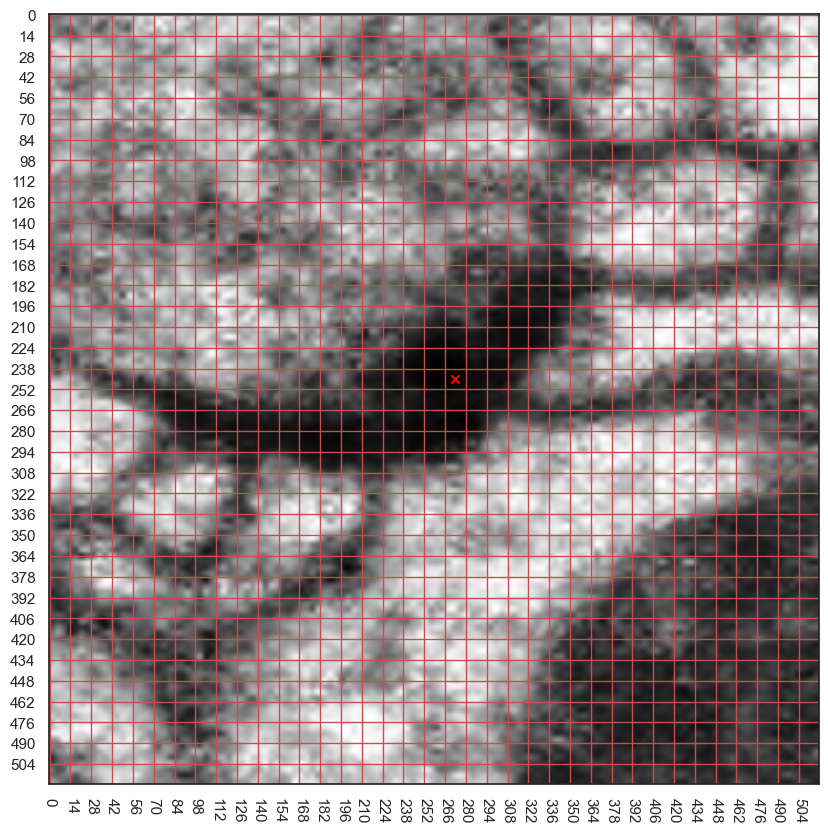

In [64]:
import torchvision
files, labels = zip(*get_fnames()) 
image = torch.from_numpy(load_image(files[0])[0])
resized_image = Trans.Resize(size=resize_size, interpolation=torchvision.transforms.InterpolationMode.BICUBIC, antialias=True)(image).permute(1,2,0).numpy()
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(resized_image, cmap='grey')
plt.xticks([i for i in range(0,518,14)])
plt.yticks([i for i in range(0,518,14)])
plt.grid(True, color='r', linewidth=1)
plt.xticks(rotation = -90)
ref_coords = (273,245) 
plt.scatter(273,245, marker='x', c='red')
plt.show()

## Adding more reference points

In [312]:
from itertools import product

possibilities = list(product((14,-14, 0),repeat=2))

augmentations = [np.add(ref_coords,possibility) for possibility in possibilities]
augmented_ref_coordinates = [(0, a[0], a[1]) for a in augmentations]

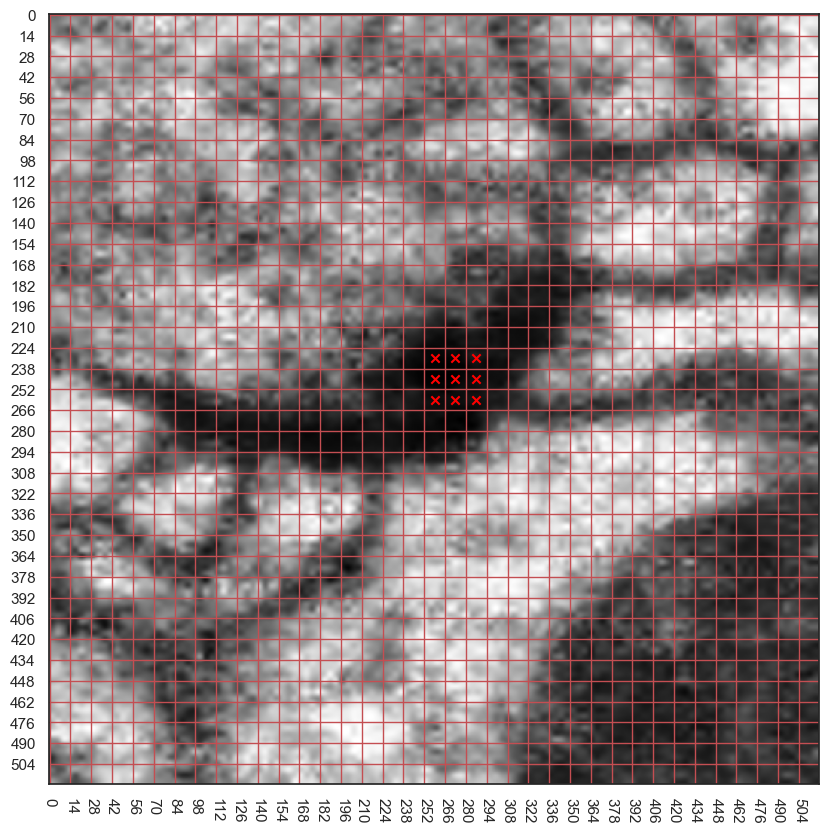

In [313]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(resized_image, cmap='grey')
plt.xticks([i for i in range(0,518,14)])
plt.yticks([i for i in range(0,518,14)])
plt.grid(True, color='r', linewidth=1)
plt.xticks(rotation = -90)
x,y=zip(*augmentations)
plt.scatter(x,y, marker='x', c='red')
plt.show()

Precomputing embeddings


100%|██████████| 1/1 [00:16<00:00, 16.99s/it]
/var/folders/nd/k2k1v8713rb4g77z7z6mbxn80000gn/T/ipykernel_5479/2742523267.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  similarity_list.append(np.dot(ref, patch)/(np.linalg.norm(ref)*np.linalg.norm(patch)))


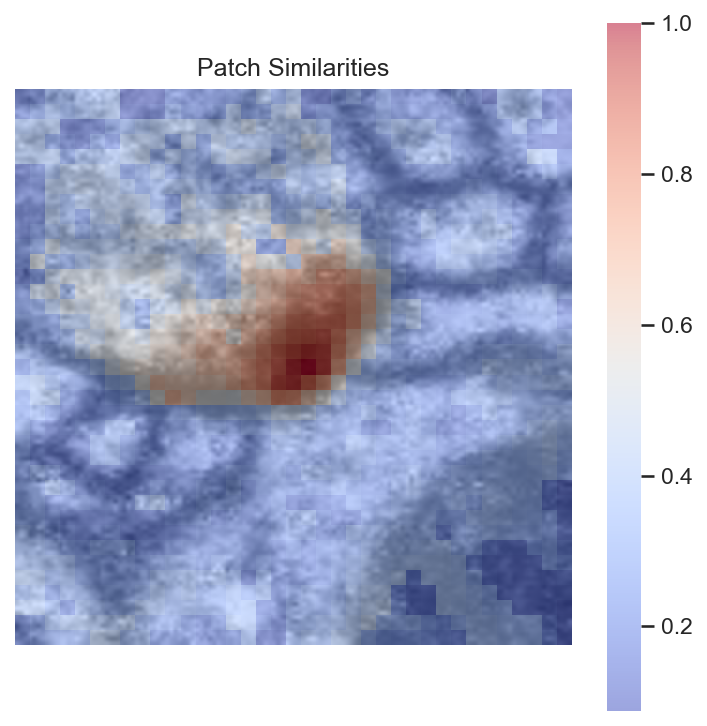

In [315]:
few_shot.pre_compute_embeddings(
    dataset=resized_image[None,:,:,:], 
    batch_size=1
    )
embeddings = few_shot.get_embeddings(reshape=True)

few_shot.set_reference_vector([(0,273,245)])
ref = few_shot.get_reference_embedding()

nb_patches_per_dim = int((resize_size/14))

similarity_list = []
for patch in embeddings:
    similarity_list.append(np.dot(ref, patch)/(np.linalg.norm(ref)*np.linalg.norm(patch)))

patch_similarities = np.array(similarity_list).reshape(nb_patches_per_dim, nb_patches_per_dim)

h, w = patch_similarities.shape

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

# Show the background image
ax.imshow(resized_image, cmap='gray', extent=[0, h, w, 0])

# Overlay the heatmap
sns.heatmap(
    patch_similarities,
    cmap='coolwarm',
    alpha=0.5,             # Make the heatmap semi-transparent
    ax=ax,
    cbar=True,
    xticklabels=False,
    yticklabels=False
)

plt.title("Patch Similarities")
plt.tight_layout()
plt.show()

Precomputing embeddings


100%|██████████| 1/1 [00:26<00:00, 26.08s/it]
/var/folders/nd/k2k1v8713rb4g77z7z6mbxn80000gn/T/ipykernel_5479/1924679119.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  similarity_list.append(np.dot(ref, patch)/(np.linalg.norm(ref)*np.linalg.norm(patch)))


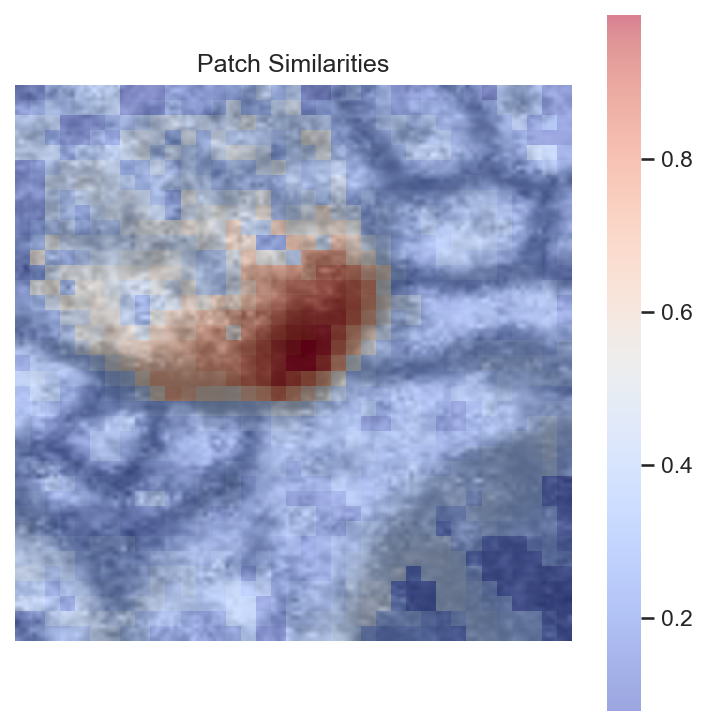

In [314]:
few_shot.pre_compute_embeddings(
    dataset=resized_image[None,:,:,:], 
    batch_size=1
    )
embeddings = few_shot.get_embeddings(reshape=True)

#few_shot.set_reference_vector([(0,273,245)])
few_shot.set_reference_vector(augmented_ref_coordinates)
ref = few_shot.get_reference_embedding()

nb_patches_per_dim = int((resize_size/14))

similarity_list = []
for patch in embeddings:
    similarity_list.append(np.dot(ref, patch)/(np.linalg.norm(ref)*np.linalg.norm(patch)))

patch_similarities = np.array(similarity_list).reshape(nb_patches_per_dim, nb_patches_per_dim)

h, w = patch_similarities.shape

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

# Show the background image
ax.imshow(resized_image, cmap='gray', extent=[0, h, w, 0])

# Overlay the heatmap
sns.heatmap(
    patch_similarities,
    cmap='coolwarm',
    alpha=0.5,             # Make the heatmap semi-transparent
    ax=ax,
    cbar=True,
    xticklabels=False,
    yticklabels=False
)

plt.title("Patch Similarities")
plt.tight_layout()
plt.show()

Precomputing embeddings


100%|██████████| 1/1 [01:19<00:00, 79.61s/it]
/var/folders/nd/k2k1v8713rb4g77z7z6mbxn80000gn/T/ipykernel_5479/2933279460.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  latents = np.array(few_shot.get_embeddings()) # should be of shape (nb_slices, nb_patches, embedding_dim)
/var/folders/nd/k2k1v8713rb4g77z7z6mbxn80000gn/T/ipykernel_5479/2961693355.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  similarity_list.append(np.dot(augmented_ref, patch)/(np.linalg.norm(aug

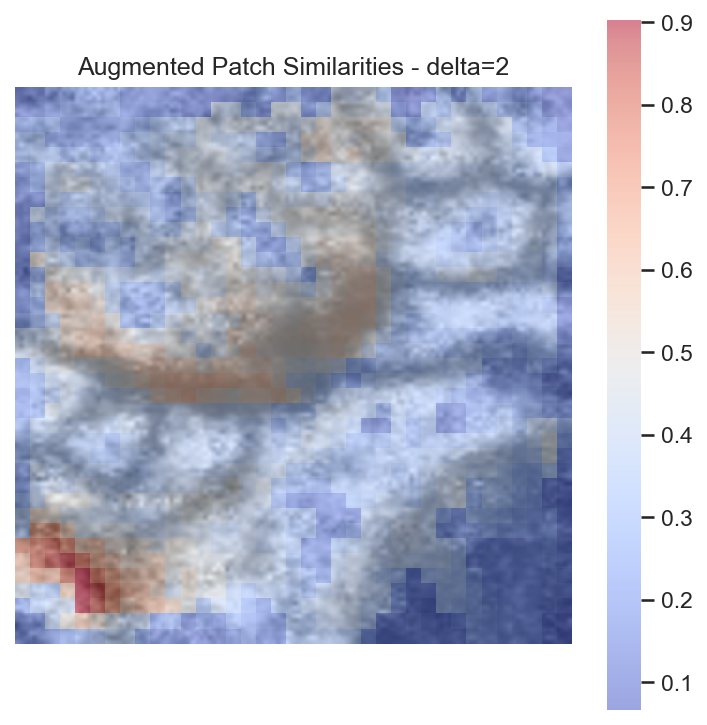

In [14]:
delta = 2

context_patches, augmented_ref = add_context_to_embeddings(files[0], delta=delta)

nb_patches_per_dim = int((resize_size/14))

similarity_list = []
for patch in context_patches:
    similarity_list.append(np.dot(augmented_ref, patch)/(np.linalg.norm(augmented_ref)*np.linalg.norm(patch)))

patch_similarities = np.array(similarity_list).reshape(nb_patches_per_dim, nb_patches_per_dim)

h, w = patch_similarities.shape

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

# Show the background image
ax.imshow(resized_image, cmap='gray', extent=[0, h, w, 0])

# Overlay the heatmap
sns.heatmap(
    patch_similarities,
    cmap='coolwarm',
    alpha=0.5,
    ax=ax,
    cbar=True,
    xticklabels=False,
    yticklabels=False
)

plt.title(f"Augmented Patch Similarities - delta={delta}")
plt.tight_layout()
plt.show()

In [283]:
import umap
reducer = umap.UMAP(random_state=42)
embeddings_and_ref = np.vstack([ref,embeddings])

N = nb_patches_per_dim

center = (ref_coords[1]//14+1,ref_coords[0]//14+1)
row, col = np.ogrid[:N, :N]

distance_matrix = np.abs(N - np.maximum(np.abs(row - center[0]), np.abs(col - center[1])) - nb_patches_per_dim)

distances = []
for i in range(nb_patches_per_dim):
    for j in range(nb_patches_per_dim):
        distances.append(distance_matrix[i,j])

umap_embeddings = reducer.fit_transform(embeddings_and_ref)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


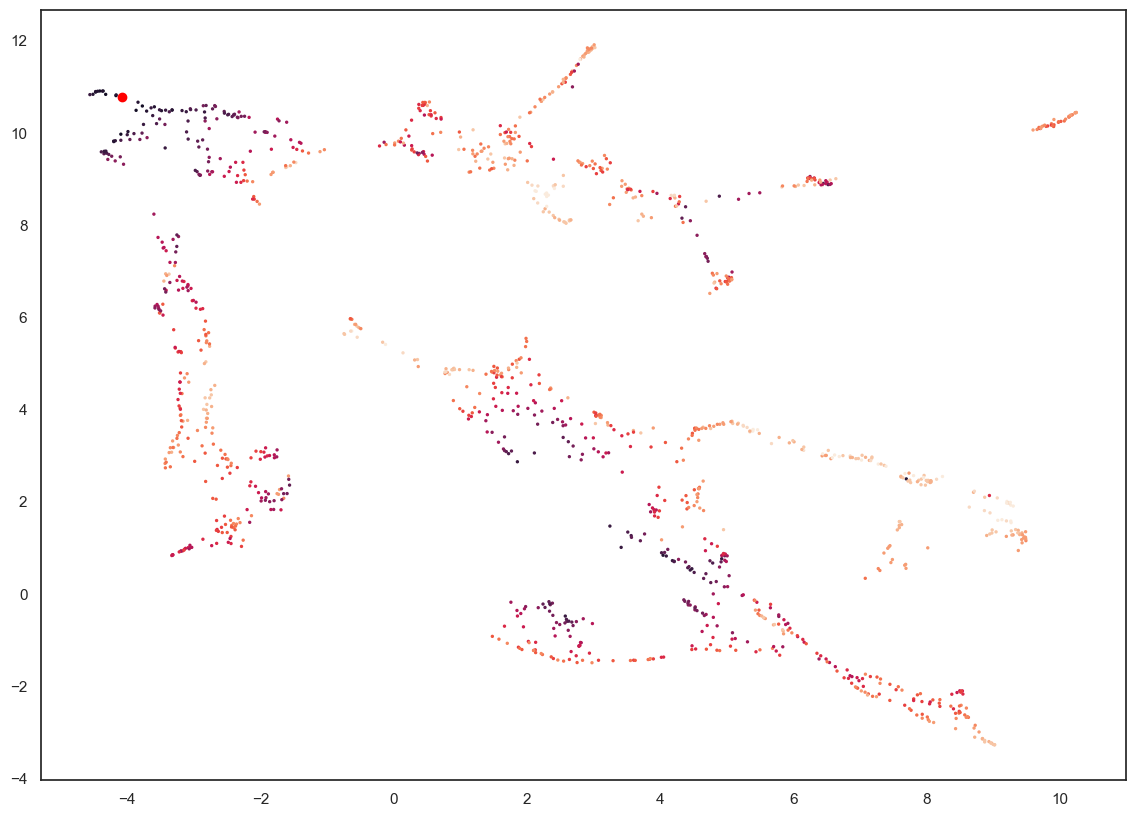

In [284]:
plt.scatter(umap_embeddings[1:,0], umap_embeddings[1:,1], c=distances, s=2)
plt.scatter(umap_embeddings[0,0], umap_embeddings[0,1], c='red', marker='o')

In [285]:
from io import BytesIO
from PIL import Image
import base64

In [286]:
def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [287]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.palettes import Inferno256  

output_notebook()

Loading BokehJS ...

In [288]:
patch_blocks = resized_image.reshape(37, 14, 37, 14)
patch_blocks_list = []
coords_list = []
for i in range(nb_patches_per_dim):
    for j in range(nb_patches_per_dim):
        patch_blocks_list.append(patch_blocks[i,:,j,:])
        coords_list.append((i,j))

In [289]:
digits_df = pd.DataFrame(umap_embeddings, columns=('x', 'y'))

coordinates = [coord for coord in coords_list]
coordinates = coordinates[::-1]
coordinates.append((ref_coords[1]//14+1,ref_coords[0]//14+1))
coordinates = coordinates[::-1]
digits_df['Position'] = coordinates

patch_blocks_list = patch_blocks_list[::-1]
patch_blocks_list.append(patch_blocks[ref_coords[1]//14+1,:,ref_coords[0]//14+1,:])
patch_blocks_list = patch_blocks_list[::-1]
digits_df['image'] = list(map(embeddable_image, patch_blocks_list))

distances.insert(0,0)
digits_df['Color'] = distances

datasource = ColumnDataSource(digits_df)
color_mapper = LinearColorMapper(palette=Inferno256, low=digits_df['Color'].min(), high=digits_df['Color'].max())

plot_figure = figure(
    title='UMAP projection of image',
    width=1500,
    height=1500,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Position:</span>
        <span style='font-size: 18px'>@Position</span>
    </div>
</div>
"""))

plot_figure.scatter(
    'x',
    'y',
    source=datasource,
    color={'field': 'Color', 'transform': color_mapper},
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
show(plot_figure)
